In [1]:
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from utils_image import get_meanZstack
from scanimagetiffio import SITiffIO

In [3]:
datafolder = '/home/zilong/Desktop/2D2P/Data/183_28072023/'
# read the rotation center from the circlecenter txt file
circlecenterfilename = datafolder+"DP_exp/circlecenter.txt"
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])
print("Rotation center is at ({}, {})".format(rotx, roty))

tiffpath = datafolder + 'stack28072023_00005.tif'
logpath = datafolder + 'REdata_20230728_190540.stack00005.txt'
volume = 1; stacks=71; frames=200; Rotcenter=[rotx, roty]; ImgReg=False

S = SITiffIO()
S.open_tiff_file(tiffpath, "r")
S.open_rotary_file(logpath)
S.interp_times() 
meanZ = get_meanZstack(S, volume, stacks, frames, Rotcenter, ImgReg)

#visualize 
if not os.path.exists(datafolder+'meanZstacks'):
    os.makedirs(datafolder+'meanZstacks')
for i in range(meanZ.shape[0]):
    frame_i = meanZ[i,:,:]
    plt.imshow(frame_i, cmap='gray')
    plt.axis('off')
    plt.savefig(datafolder+'meanZstacks/'+'stack'+str(i+1)+'.png')

Rotation center is at (268.0, 253.0)
Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/183_28072023/REdata_20230728_190540.stack00005.txt
Finished calculating rotations and times.
The rotary encoder file has 61769 timestamps in it.
Counted 14200 frames
Extract the mean frame of Zstacks...
Processing stack 0
Processing stack 1
Processing stack 2
Processing stack 3
Processing stack 4
Processing stack 5
Processing stack 6
Processing stack 7
Processing stack 8
Processing stack 9
Processing stack 10
Processing stack 11
Processing stack 12
Processing stack 13
Processing stack 14
Processing stack 15
Processing stack 16
Processing stack 17
Processing stack 18
Processing stack 19
Processing stack 20
Processing stack 21
Processing stack 22
Processing stack 23
Processing stack 24
Processing stack 25
Processing stack 26
Processing stack 27
Processing stack 28
Processing stack 29
Processing stack 30
Processing stack 31
Processing stack 32
Processing stack 33
Processing stack 34
Processing

In [7]:
#test the index of the zstack
import numpy as np
stack_i=0;frames=200; stacks=41; volume=2
inds = np.zeros((volume*frames))
for vi in range(volume):
    ind_in_vloume = vi*stacks*frames+np.arange(stack_i*frames,(stack_i+1)*frames,1)
    inds[vi*frames:(vi+1)*frames] = ind_in_vloume
print(np.int32(inds))

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  187  188  189  190  191  192  193  194  195
  196 

In [3]:
#load the zstack tiff and calculate the mean frames for each stack
#this code will be mmeory intensive if ztsack is big

zstacktiff = datafolder+'stack28072023_00005.tif'
ztstackrelog = datafolder+'REdata_20230728_190540.stack00005.txt'

num_v=1; num_s=41; num_f=100



S = SITiffIO()
S.open_tiff_file(zstacktiff, "r")
S.open_rotary_file(ztstackrelog)
S.interp_times()  # might take a while...

#get all frames and angles in S
Array = []; 
for i in range(S.get_n_frames()):
    Array.append(S.get_frame(i+1))
#change Array to a numpy array
Array = np.array(Array)
Angle = S.get_all_theta()

# unrotate each frame in the tiff file with the detected rotation center
unrotcropFrames = UnrotateCropFrame(Array, Angle, rotCenter=[262,259])


num_v=1; num_s=41; num_f=100
# reshape the unrotFrames to a 5D array
unrotcropFrames = unrotcropFrames.reshape(
    num_v, num_s, num_f, unrotcropFrames.shape[1], unrotcropFrames.shape[2]
)
# average across the first and third dimension
meanZstacks = np.mean(unrotcropFrames, axis=(0, 2))

Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/183/REdata_20230725_160414.txt
Finished calculating rotations and times.
The rotary encoder file has 17935 timestamps in it.
Counted 4100 frames


In [6]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

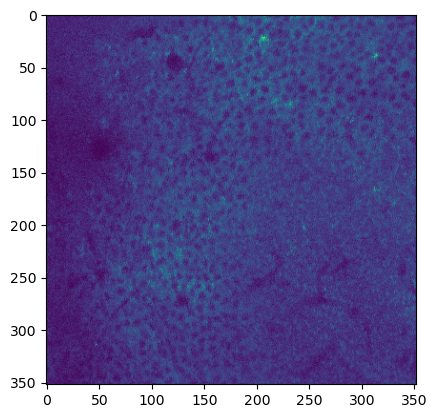

In [8]:
#visualize each frames in the meanZstacks and save it to a folder 
firstframe = meanZstacks[0,:,:]
for i in range(meanZstacks.shape[0]):
    new_frame_i = meanZstacks[i,:,:]
    if i>0:
        frame_i = meanZstacks[i,:,:]
        #histogram matching to the first frame
        new_frame_i = hist_match(frame_i, firstframe)
    plt.imshow(new_frame_i)
    plt.savefig('/home/zilong/Desktop/2D2P/Data/183/DP/meanZstacks/meanZstacks'+str(i+1)+'.png')

In [7]:
tiff = '/home/zilong/Desktop/2D2P/Data/182_01082023/stack01082023_00003.tif'
relog = '/home/zilong/Desktop/2D2P/Data/182_01082023/REdata_20230801_180211.stack00003.txt'
S = SITiffIO()
S.open_tiff_file(tiff, "r")
S.open_rotary_file(relog)
S.interp_times()  # might take a while...
    

Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/182_01082023/REdata_20230801_180211.stack00003.txt
Finished calculating rotations and times.
The rotary encoder file has 43745 timestamps in it.
Counted 14200 frames


In [ ]:

frames = np.zeros((512,512))
for i in range(200):
    frame_i = S.get_frame(i+1)
    frames += frame_i/200

plt.imshow(frames)   
    

In [8]:
allmeanZ = np.zeros((71,512,512))
for j in range(71):
    print(j)
    frames = np.zeros((512,512))
    for i in range(200):
        frame_i = S.get_frame(200*j+i+1)
        frames += frame_i/200
    allmeanZ[j] = frames
        

In [3]:
import numpy as np
import matplotlib.pyplot as plt
meanZ = np.load('/home/zilong/Desktop/2D2P/Data/182_02082023/fullZ.npy')

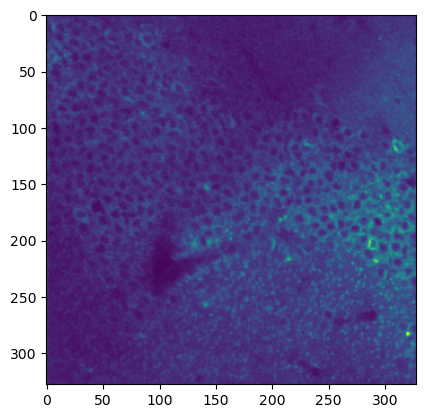

In [6]:
plt.imshow(meanZ[35])